<a href="https://colab.research.google.com/github/Zhen-Miao/PIC-snATAC/blob/main/vignettes/Run_PIC_counting_on_pbmc_3k_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run PIC counting on pbmc_3k data


## Content and Dataset
Here in this notebook, we aim to use PIC counting to construct a peak-by-cell matrix with the uniform preprocessing step in PIC. We use the PBMC-3k data that are publicly available in the 10X Genomics website 

[10X Genomics Dataset](https://www.10xgenomics.com/resources/datasets)

## Step 1. Install packages

In [1]:
install.packages('devtools')
install.packages('data.table') ## (please make sure it is newer than 1.8)
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("GenomeInfoDb","Rsamtools","IRanges"))
devtools::install_github("Zhen-Miao/PIC-snATAC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘textshaping’, ‘shiny’, ‘downlit’, ‘ragg’, ‘htmlwidgets’, ‘miniUI’, ‘pkgdown’, ‘profvis’, ‘urlchecker’


Warning message in install.packages("devtools"):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘pkgdown’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘devtools’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "Bioc

Skipping 4 packages not available: GenomeInfoDb, Rsamtools, GenomicRanges, IRanges



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpknFoFP/remotes779ab34e99/Zhen-Miao-PIC-snATAC-dc73a1d/DESCRIPTION’ ... OK
* preparing ‘PICsnATAC’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘PICsnATAC_0.2.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [13]:
## install additional libraries
install.packages('R.utils')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’




## Step 2. Load required libraries


In [2]:
library('data.table')
library('GenomicRanges')
library('Matrix')
library('PICsnATAC')

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


At

## Step 3. Prepare for input files
We will need to following input from Cell Ranger output:


*   cell barcodes with metadata (`singlecell.csv`)
*   list of peak regions (`peaks.bed`)
*  fragment files (`fragment.tsv.gz`)






In [15]:
## read cell metadata
meta.data <- read.csv('/content/pbmc_unsorted_3k_per_barcode_metrics.csv', header = T )
# -- in your own Cell Ranger output, the file name will be 'singlecell.csv'
# or 'per_barcode_metrics.csv'
meta.data_filtered <- meta.data[meta.data$is_cell == 1,]
cells <- meta.data_filtered$barcode

In [16]:
print(head(cells))

[1] "AAACAGCCAACAGGTG-1" "AAACATGCAACAACAA-1" "AAACATGCACCTGGTG-1"
[4] "AAACCAACACAGCCTG-1" "AAACCAACAGCAAGAT-1" "AAACCAACATTGCGAC-1"


In [6]:
## load the list of peaks
peaks <- data.table::fread('/content/pbmc_unsorted_3k_atac_peaks.bed',header = F)
# -- in your own Cell Ranger output, the file name will be 'peaks.bed'
colnames(peaks) <- c('seqname', 'start', 'end')
peak_sets = GenomicRanges::makeGRangesFromDataFrame(peaks)

In [8]:
print(peak_sets)

GRanges object with 81156 ranges and 0 metadata columns:
            seqnames        ranges strand
               <Rle>     <IRanges>  <Rle>
      [1]       chr1    9782-10672      *
      [2]       chr1 180547-181446      *
      [3]       chr1 191121-191998      *
      [4]       chr1 267553-268447      *
      [5]       chr1 270906-271782      *
      ...        ...           ...    ...
  [81152] KI270711.1   22605-23472      *
  [81153] KI270713.1     3924-4839      *
  [81154] KI270713.1   21448-22354      *
  [81155] KI270713.1   26202-26986      *
  [81156] KI270713.1   36937-37838      *
  -------
  seqinfo: 37 sequences from an unspecified genome; no seqlengths


The peaks directly from Cell Ranger output are usually wider, so people can alternatively use MACS2 to call peaks and use the new peak set. 

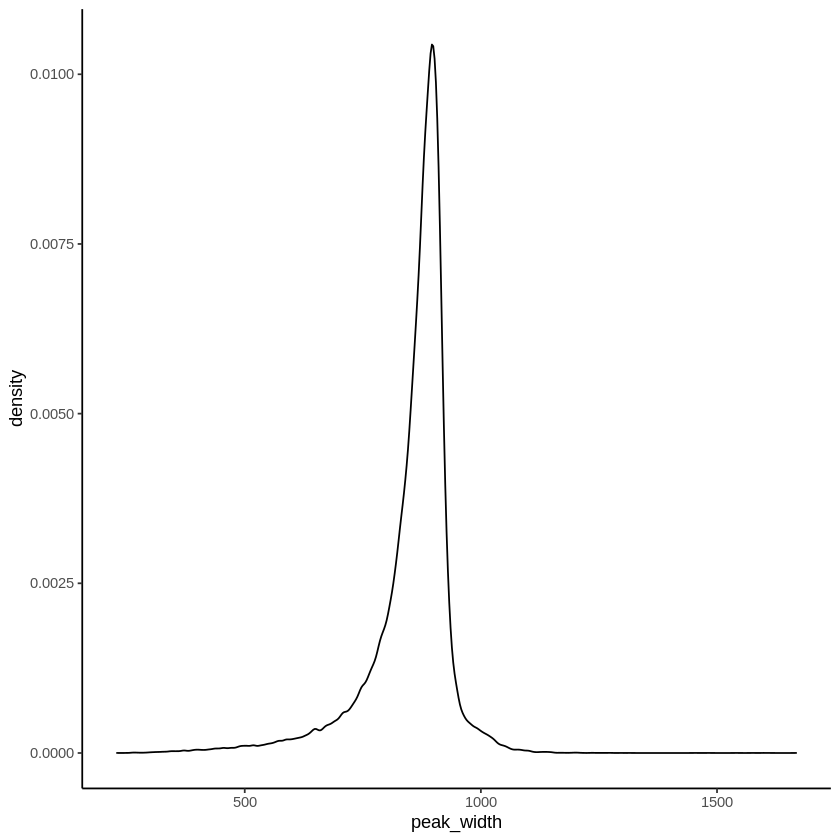

In [10]:
library('ggplot2')
pwidth = as.integer(peaks$end) - as.integer(peaks$start)
df = data.frame(peak_width = pwidth)
ggplot(data = df, aes(x = peak_width))+
  geom_density()+
  theme_classic()

We can see most of the peaks are between ~600 bp and 1000 bp. Much longer than the usual peak width in MACS2 narrow-peak setting. 

In [11]:
## fragment files
fragment_tsv_gz_file_location <- '/content/pbmc_unsorted_3k_atac_fragments.tsv.gz'

## Step 4. Run PIC counting module and save output
Based on the number of cells processed, this may take a while. It is recommended that this step to run in computing clusters. There will be a progress bar for the computing 

In [ ]:
pic_mat <- PIC_counting(
  cells = cells,
  fragment_tsv_gz_file_location = fragment_tsv_gz_file_location,
  peak_sets = peak_sets)

[1] "all fragment data loaded"
[1] "computing peak vector for each cell"

In [ ]:
## If the fragment file is large and preprocessing is run locally,
## it is recommended to use Rsamtools to reduce RAM usage. 
## This is easy with PIC function, Here are examples
pic_mat <- PIC_counting(
  cells = cells,
  fragment_tsv_gz_file_location = fragment_tsv_gz_file_location,
  peak_sets = peak_sets,
  load_full = F)

We can save the output as an .rds file for future use. This matrix can be directly loaded in Seurat or ArchR and common downstream analyses can be conducted with these pipelines. 

In [ ]:
saveRDS(pic_mat, 'PIC_mat_pbmc_3k.rds')

## Reference
For this worksheet, we used the 10X Genomics multiome public data.

If you used PIC-snATAC counting in your analysis, please cite our manuscript:

Miao Z, Kim J. Is single nucleus ATAC-seq accessibility a qualitative or quantitative measurement?. bioRxiv. 2022.